In [1]:
import pandas as pd
import numpy as np
import requests
import math
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# TuTCI strategies testing
* test1: tutci enter, tutci exit
* test2: tutci enter, custom exit when profit > 10

## Download data or import if already downloaded (OKX)

In [2]:
def rest_get_sign(url, **params):
    return requests.get(url, params=params)

def create_filename(symbol, start_date, end_date, timeframe, prefix=''):
    return f'{prefix}{symbol} {timeframe} {start_date.year}_{start_date.month} {end_date.year}_{end_date.month}.csv'

def get_history_candles(symbol, start_date, end_date=None, tf=15, save_path='market_data'):
    if end_date is None:
        end_date = datetime.datetime.now()
        
    timeframe = str(tf) + 'm' if tf < 31 else str(tf // 60) + 'H'
    filename = create_filename(symbol, start_date, end_date, timeframe)
    
    if not os.path.exists(save_path):
        os.mkdir(save_path)
        
    if filename in os.listdir(save_path):
        print(f'Loading from \'{save_path}\' : {filename}')
        df = pd.read_csv(f'{save_path}/{filename}', index_col='datetime')
        df.index = pd.to_datetime(df.index)
        return df
        
    

    print(f'Downloading data for {symbol}|{timeframe} : {start_date} -> {end_date}')
    data = []
    time = end_date
    
    while time > start_date:
        resp = rest_get_sign('https://www.okx.com/api/v5/market/history-candles', instId=symbol, bar=timeframe, after=int(time.timestamp() * 1000))
        data += resp.json()['data']
        time -= 100 * datetime.timedelta(minutes=tf)

    df = pd.DataFrame(data, columns=['datetime', 'open', 'high', 'low', 'close', 'volume', 'volumeCcy'])
    df = df.astype('float')
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
    df['symbol'] = symbol
    df['exchange'] = 'OKX'
    df['timeframe'] = tf
    df = df.set_index('datetime', drop=True)

    df = df[ df.index >= start_date]
    df = df.drop_duplicates()
    df = df[::-1]

    df.to_csv(f'{save_path}/{filename}')
        
    return df

## Tutci indicator

* Needs history of 'entr_length + 1' closed candles and curent market data
* Makes a descision buy/sell at curent market price

In [3]:
def crossover(x, y):
    return (x > y) & (x.shift() < y.shift())

def barssince(cond):
    ser = cond.reset_index(drop=True)
    return (ser.index - pd.Series(ser.index.where(ser)).fillna(method='ffill')).values

def tutci_online(closed_candles, candle_now, entr_length=20, exit_length=10):
    data = closed_candles.append(candle_now)
    
    high = data['high']
    low = data['low']

    up = high.rolling(window=entr_length).max()
    down = low.rolling(window=entr_length).min()

    sup = high.rolling(window=exit_length).max()
    sdown = low.rolling(window=exit_length).min()
    
    buy_signal = (high == up.shift()) | crossover(high, up.shift())
    sell_signal = (low == down.shift()) | crossover(down.shift(), low)
    buy_exit = (low == sdown.shift()) | crossover(sdown.shift(), low)
    sell_exit = (high == sup.shift()) | crossover(high, sup.shift())
    
    return buy_signal.iloc[-1], sell_signal.iloc[-1], buy_exit.iloc[-1], sell_exit.iloc[-1]

## Tutci tester

In [4]:
def test_tutci(symbol, start_date, end_date, candle_tf, tick_tf, length=20):
    save_folder='results'
    
    test_filename = create_filename(symbol, start_date, end_date, f'{candle_tf}_{tick_tf}', 'TuTCI_')
    print(test_filename)
    
    # load test if already calculated
    if not os.path.exists(save_folder):
        print('Creating folder \'{save_folder}\'')
        os.mkdir(save_folder)
        
    if test_filename in os.listdir(save_folder):
        print(f'Loading test from \'{save_folder}\n test: {test_filename}')
        df = pd.read_csv(f'{save_folder}/{test_filename}', index_col='datetime')
        df.index = pd.to_datetime(df.index)
        return df
    
    # get data
    df_candles = get_history_candles(symbol, start_date=start_date, end_date=end_date, tf=candle_tf)
    df_ticks = get_history_candles(symbol, start_date=start_date, end_date=end_date, tf=tick_tf)

    fee_rate = 0.0005
    long_open_price = 0
    short_open_price = 0

    history = pd.DataFrame()
    for i in range(length + 1, df_candles.shape[0]):
        closed_candles = df_candles.iloc[i - length - 1: i ]
        start_tick = closed_candles.index[-1] + datetime.timedelta(minutes=candle_tf)
        close_tick = start_tick + datetime.timedelta(minutes=candle_tf)
        tick = start_tick

        while tick < close_tick:
            # currnet market data
            candle_now = df_ticks.loc[tick]
            market_price = candle_now['close']
            order = None
            pnl = 0

            # indicator prediction
            long_open, short_open, long_close, short_close = tutci_online(closed_candles, candle_now, entr_length=length)

            # signal handlers
            if long_open and long_open_price == 0:
                long_open_price = market_price
                order = 'open long'
            elif long_close and long_open_price > 0:
                pnl = market_price - long_open_price - (market_price + long_open_price) * fee_rate
                long_open_price = 0
                order = 'close long'  
                
            if short_open and short_open_price == 0:
                short_open_price = market_price
                order = 'open short'

            elif short_close and short_open_price > 0:
                pnl = short_open_price - market_price - (market_price + short_open_price) * fee_rate
                short_open_price = 0
                order = 'close short'

            # save updates
            if order:
                upd = pd.DataFrame({
                    'order': order,
                    'price': market_price,
                    'pnl': pnl
                }, index=[tick])
                history = pd.concat((history, upd))
                # print(upd)

            tick += datetime.timedelta(minutes=tick_tf)

    
    history['cum_pnl'] = np.cumsum(history['pnl'])
    history.index.name = 'datetime'
    history.to_csv(f'{save_folder}/{test_filename}')
    return history

## Tutci + custom exit tester

In [5]:
def test_tutci_custom_exit(symbol, start_date, end_date, candle_tf, tick_tf, length=20, close_func=None):
    save_folder='results'
    
    if not close_func:
        print('Input close descision function...')
        return
    
    # load test if already calculated
    test_filename = create_filename(symbol, start_date, end_date, f'{candle_tf}_{tick_tf}', f'TuTCI_Custom{close_func.__name__}_')
    print(test_filename)
    
    if not os.path.exists(save_folder):
        print('Creating folder \'{save_folder}\'')
        os.mkdir(save_folder)
        
    if test_filename in os.listdir(save_folder):
        print(f'Loading test from \'{save_folder}\n test: {test_filename}')
        df = pd.read_csv(f'{save_folder}/{test_filename}', index_col='datetime')
        df.index = pd.to_datetime(df.index)
        return df
    
    # get data
    df_candles = get_history_candles(symbol, start_date=start_date, end_date=end_date, tf=candle_tf)
    df_ticks = get_history_candles(symbol, start_date=start_date, end_date=end_date, tf=tick_tf)

    fee_rate = 0.0005
    long_open_price = 0
    short_open_price = 0

    history = pd.DataFrame()
    for i in range(length + 1, df_candles.shape[0]):
        closed_candles = df_candles.iloc[i - length - 1: i ]
        start_tick = closed_candles.index[-1] + datetime.timedelta(minutes=candle_tf)
        close_tick = start_tick + datetime.timedelta(minutes=candle_tf)
        tick = start_tick

        while tick < close_tick:
            # currnet market data
            candle_now = df_ticks.loc[tick]
            market_price = candle_now['close']
            order = None
            pnl = 0

            # indicator prediction
            open_long, open_short, _, _ = tutci_online(closed_candles, candle_now, entr_length=length)
            close_long = close_func(long_open_price, market_price, long=True)
            close_short = close_func(short_open_price, market_price, long=False)
            
            
            # signal handlers
            if open_long and long_open_price == 0:
                long_open_price = market_price
                order = 'open long'
                
            elif close_long and long_open_price > 0:
                pnl = market_price - long_open_price - (market_price + long_open_price) * fee_rate
                long_open_price = 0
                order = 'close long'
                
            if open_short and short_open_price == 0:
                short_open_price = market_price
                order = 'open short'
            elif close_short and short_open_price > 0:
                pnl = short_open_price - market_price - (market_price + short_open_price) * fee_rate
                short_open_price = 0
                order = 'close short'

            # save updates
            if order:
                upd = pd.DataFrame({
                    'order': order,
                    'price': market_price,
                    'pnl': pnl
                }, index=[tick])
                history = pd.concat((history, upd))
                

            tick += datetime.timedelta(minutes=tick_tf)

    
    history['cum_pnl'] = np.cumsum(history['pnl'])
    history.index.name = 'datetime'
    history.to_csv(f'{save_folder}/{test_filename}')
    return history

## Tests

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.rcParams["figure.figsize"] = (16, 8)
plt.style.use('fivethirtyeight')

In [7]:
def plot_pnl(df):
    x_ticks = df.index
    fig, ax = plt.subplots(nrows=2)
    
    sns.barplot(data=df, x=x_ticks, y='pnl', label='pnl', ax=ax[0])
    for ind, label in enumerate(ax[0].get_xticklabels()):
        if ind % 10 == 0:  
            label.set_visible(True)
        else:
            label.set_visible(False)
    sns.lineplot(data=df, x=x_ticks, y='cum_pnl', label='cumulative pnl', ax=ax[1])
    

In [8]:
def position_duration(df):
    diff = (df.index[1:] - df.index[:-1])
    
    mean = diff.mean()
    minim = diff.min()
    maxim = diff.max()
    print(f'min {minim}')
    print(f'max {maxim}')
    print(f'mean {mean}')
    return minim, maxim, mean

In [9]:
def plot_position_pnl(df):
    data = df[ (df['order'] == 'close long') | (df['order'] == 'close short')]
    sns.histplot(data=data, x='pnl', hue='order', kde=True, stat='count')
    # return pnl

### Test 1: TutCI

In [10]:
symbol = 'ETH-USDT-SWAP'
start_date=datetime.datetime(2022, 9, 1)
end_date=datetime.datetime(2022, 10, 1)
candle_tf=60
tick_tf=5

test_1 = test_tutci(
    symbol=symbol,
    start_date=start_date,
    end_date=end_date,
    candle_tf=candle_tf,
    tick_tf=tick_tf
)

TuTCI_ETH-USDT-SWAP 60_5 2022_9 2022_10.csv
Loading test from 'results
 test: TuTCI_ETH-USDT-SWAP 60_5 2022_9 2022_10.csv


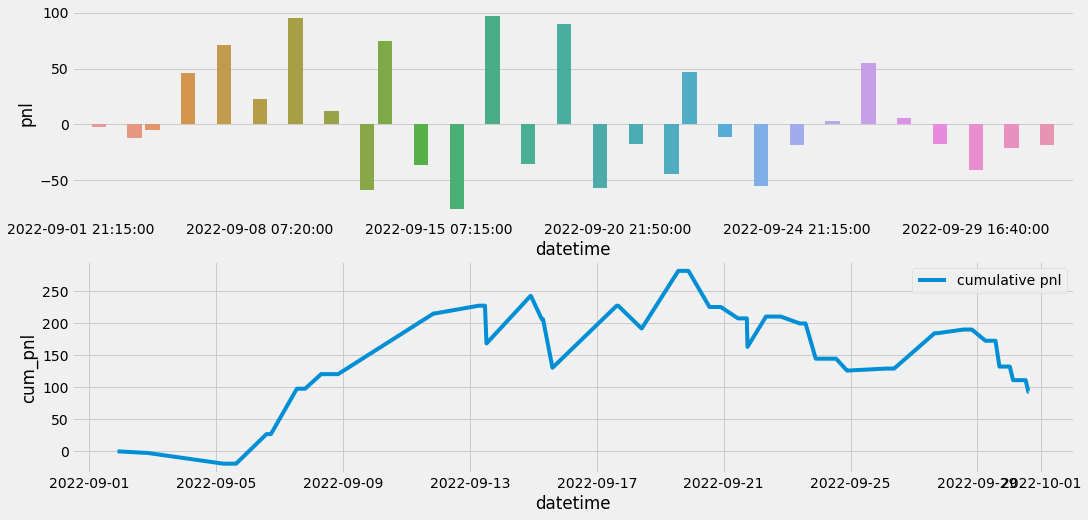

In [11]:
plot_pnl(test_1)

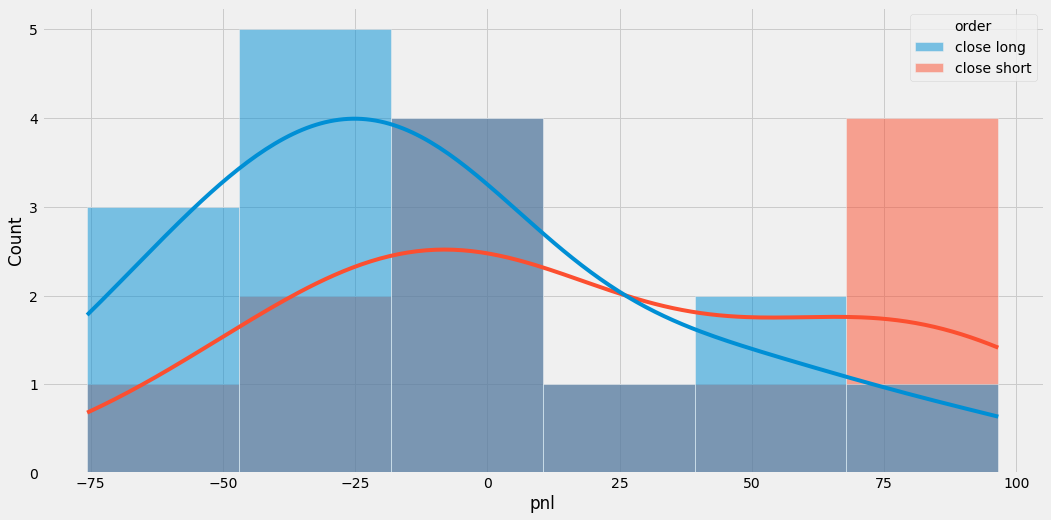

In [12]:
plot_position_pnl(test_1)

In [13]:
_ = position_duration(test_1)

min 0 days 00:05:00
max 3 days 00:25:00
mean 0 days 12:32:10.909090909


### Tutci enter, exit at price change by 10

In [14]:
def fix_diff(open_price: float, market_price: float, long: bool) -> bool:
    if long:
        return market_price - open_price > 10    
    return open_price - market_price > 10

symbol = 'ETH-USDT-SWAP'
start_date=datetime.datetime(2022, 9, 1)
end_date=datetime.datetime(2022, 10, 1)
candle_tf=60
tick_tf=5

test_2 = test_tutci_custom_exit(
    symbol=symbol,
    start_date=start_date,
    end_date=end_date,
    candle_tf=candle_tf,
    tick_tf=tick_tf,
    close_func=fix_diff
)

TuTCI_Customfix_diff_ETH-USDT-SWAP 60_5 2022_9 2022_10.csv
Loading test from 'results
 test: TuTCI_Customfix_diff_ETH-USDT-SWAP 60_5 2022_9 2022_10.csv


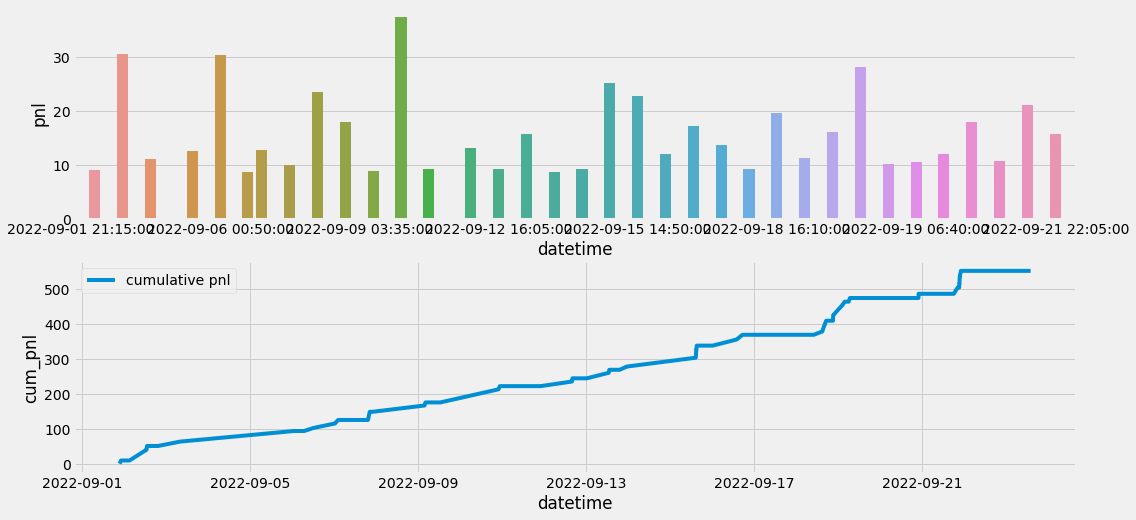

In [15]:
plot_pnl(test_2)

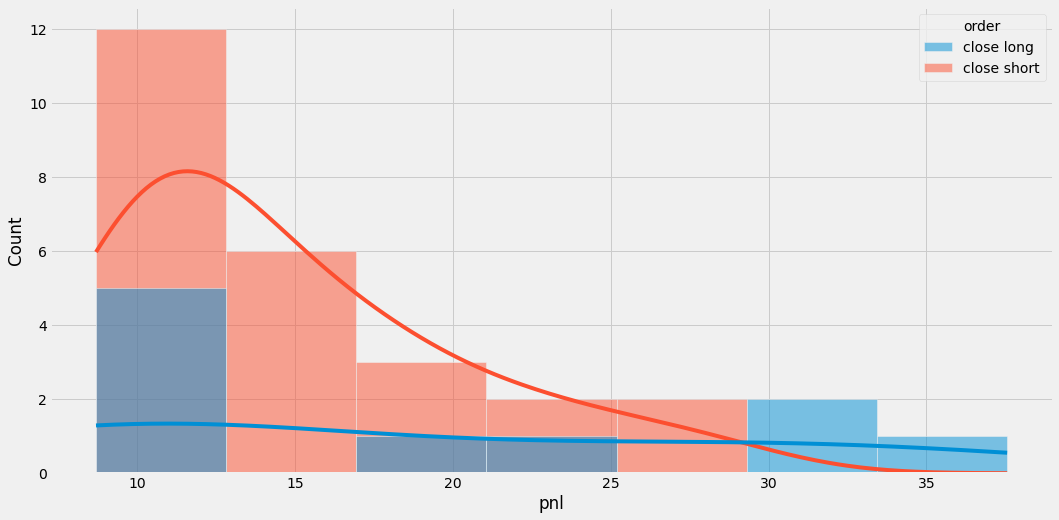

In [16]:
plot_position_pnl(test_2)

In [17]:
_ = position_duration(test_2)

min 0 days 00:05:00
max 2 days 16:55:00
mean 0 days 07:20:00
